# Abstract

# Introduction

In order to determine the efficiency of the medicines, surgery and treatment regimens used in Intensive Care Units (ICU), the prediction of mortality rate is an important parameter. This project aim is to develop a generative model that can predict the chance of survival of patients based on their clinical heath record. The data used in this project is the summary of a patient´s first 24 hours of intensive care. HI-VAE is utilized to deal with several common characteristics of real-life healthcare data, including heterogeneous covariates and missing values. We will train the model on a dataset containing many missing observation and attempt to fill them with values drawn from different distributions. The link to the source code is included in the appendix section.


# Data 

## Analysis

Loading dataset

> Dataset: 91713 samples, 184 covariates.

The covariates are indentified by some categories. We will not go into details how these categories are measured. Instead, we will visualize the missing covariates based on the categories.

There 10 different categories:
- labs
- APACHE grouping
- labs blood gas
- GOSSIS example prediction
- APACHE prediction
- vitals
- demographic
- APACHE comorbidity
- APACHE covariate
- identifier

We will randomly sample 10000 data points from the dataset and visualizing the missing covariates for some categories.

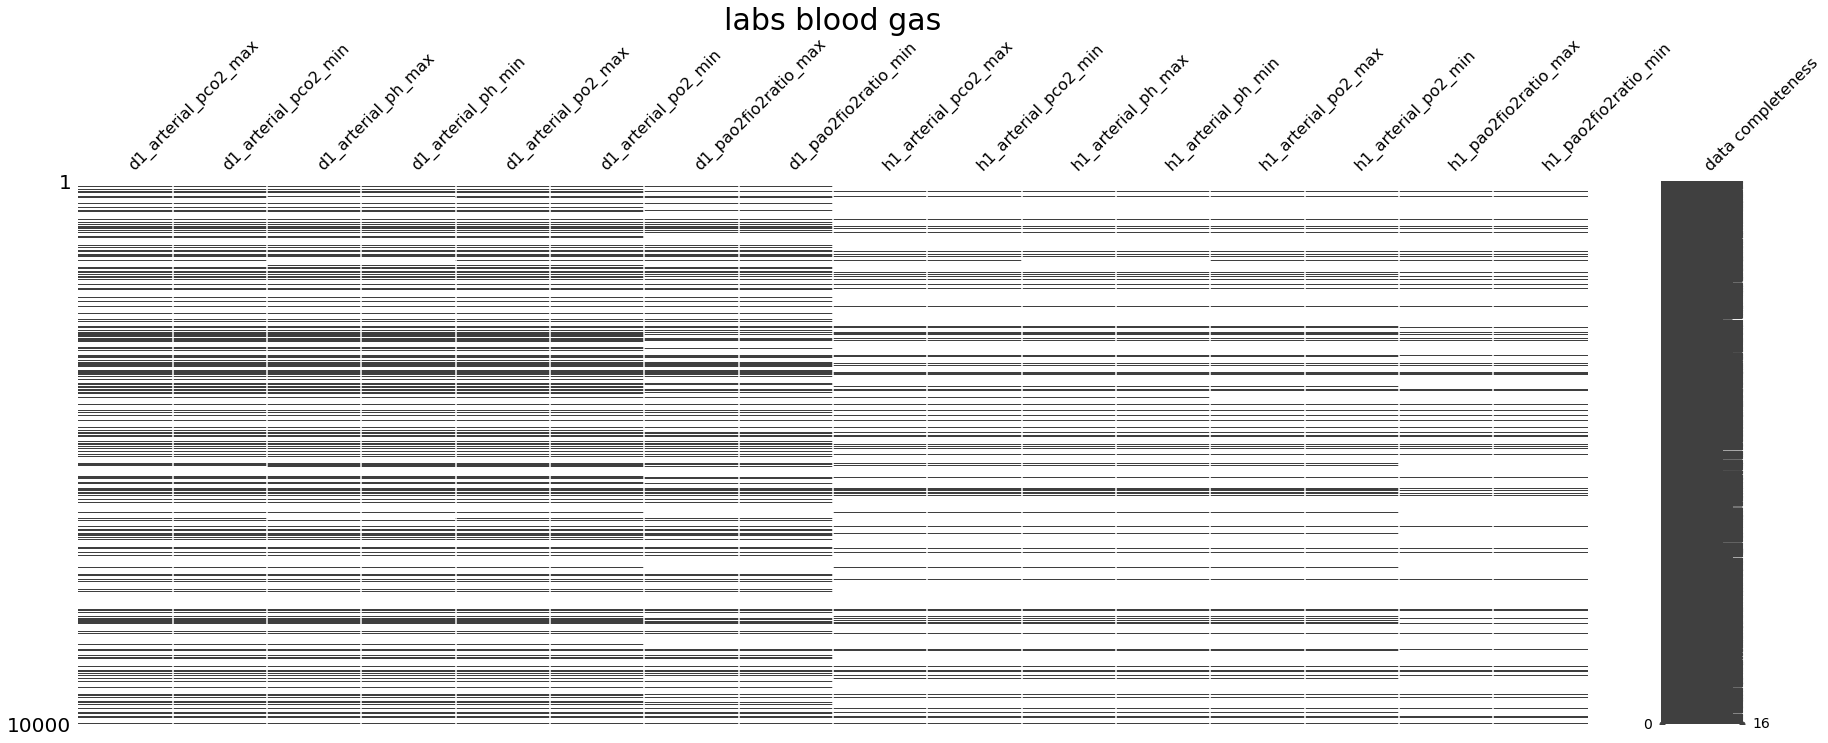

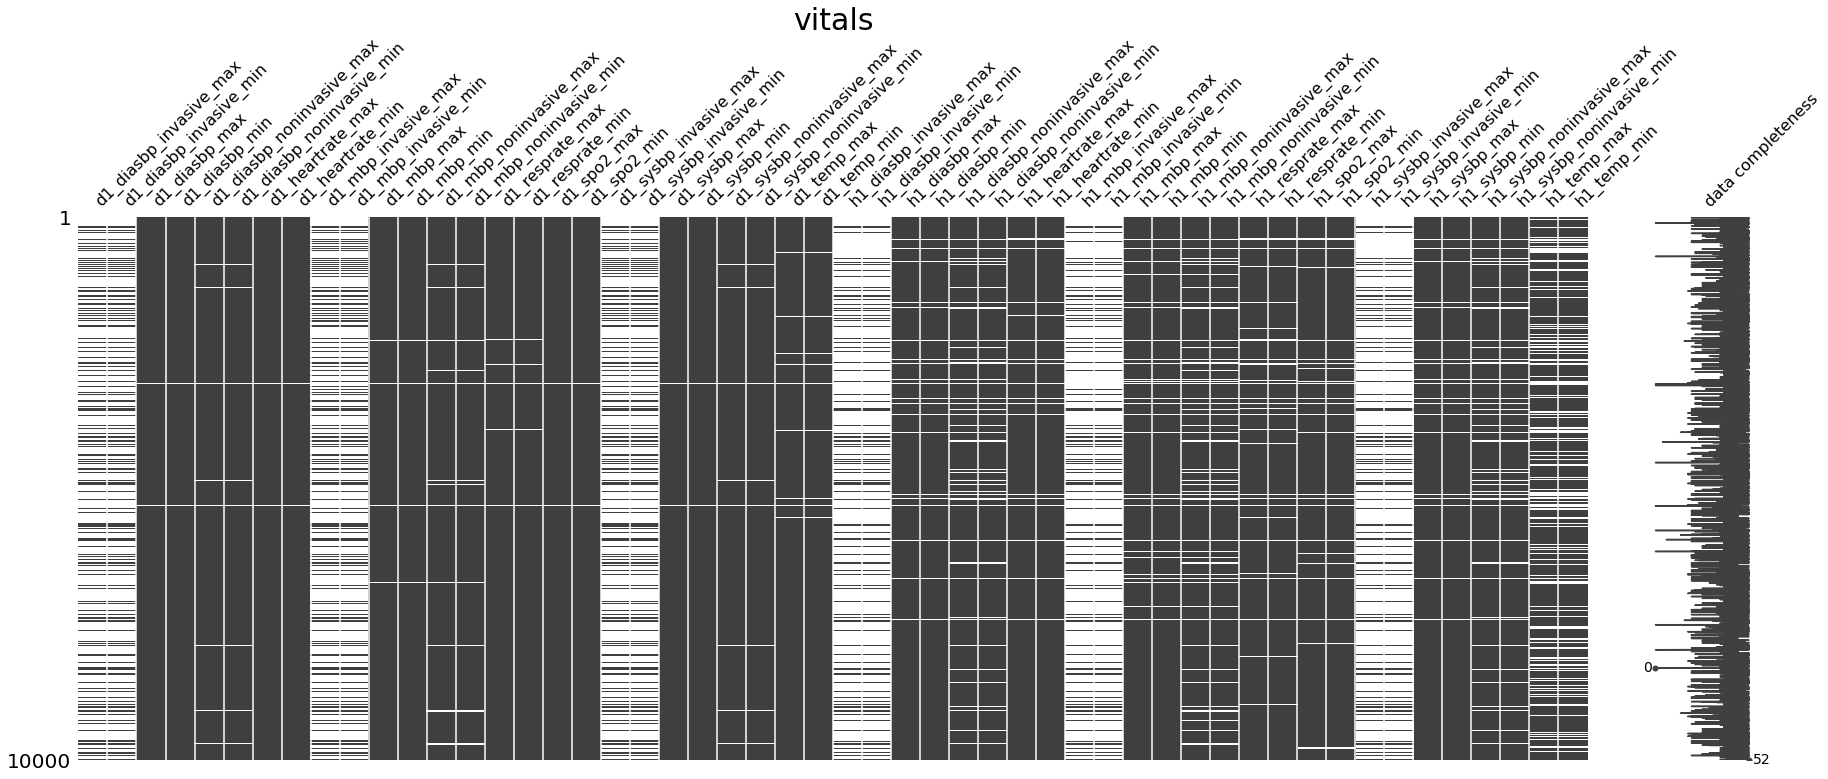

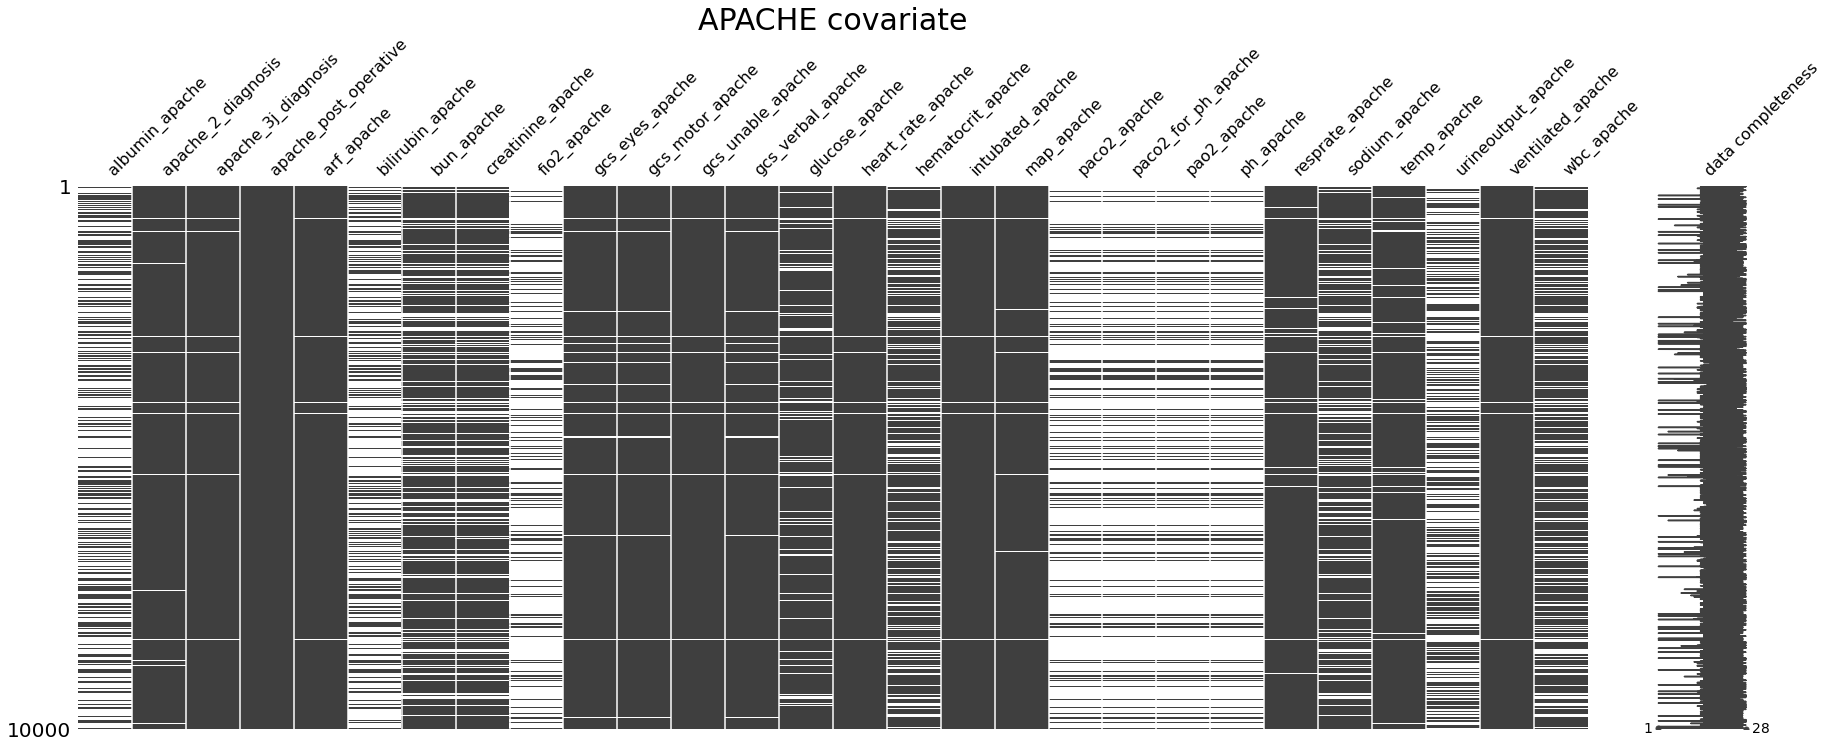

In [21]:
def visualize_missing_cov(df):
    samples_df = df.sample(10000)

    for cat in uniq_categories:
        if cat in ["vitals", "APACHE covariate", "labs blood gas"]:

            col_list = dt.loc[dt['Category'] == cat]["Variable Name"]
            col_list = [col for col in col_list if col in samples_df.columns]
            cat_df = pd.DataFrame(samples_df,columns=col_list)
            
            ax = mno.matrix(cat_df,figsize=(30, 10), labels=True)
            ax.set_title(cat, fontsize=30)
        
visualize_missing_cov(train_df)

Furthermore, we can visualize the frequency of missing values per column

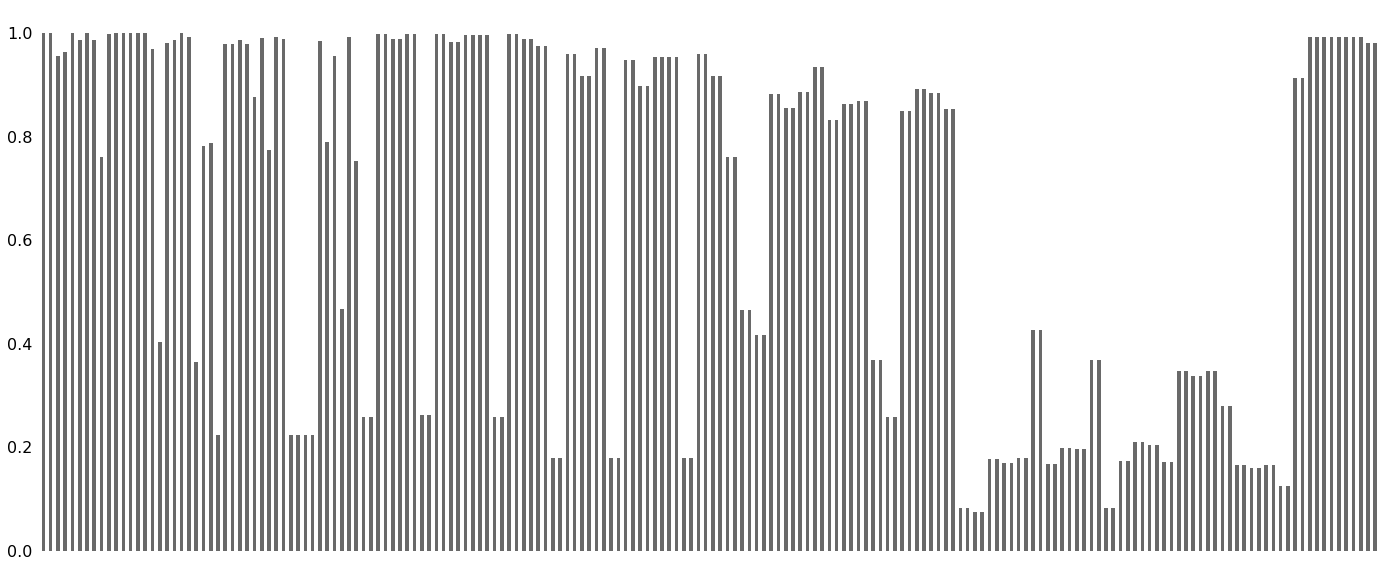

In [20]:
samples_df = train_df.sample(10000)
bar_ax = mno.bar(samples_df)

We can observe that there are many missing observations in the dataset. In general, not all covariates are necessary and some will have more impact on the patient's wellbeing than the others. At this point it is impossible to determine the effects of each covariate from non-probabilistic feature engineering (eg: PCA) due to the volume of missing data. We suggest that feature engineering should be done after the training step, when the data is fully imputed. 

## Data preprocessing

Partitioning data types to file. The file must be in the following format for the model to recognize:

> 
    type  dim  nclass
    0  pos    1     NaN
    1  cat    2     2.0
    2  pos    1     NaN
    3  pos    1     NaN
    4  cat    2     2.0

The possible values type can be inferred from the model source codes [2].

Train/Test sets splitting with a ratio of 80-20. 

> 
    Train dataset: 73370 samples, 184 covariates
    Test dataset: 18343 samples, 184 covariates

Next, we will partition the missing data positions into two separate files, one for train data set and one for test dataset. Note that since we are trying to predict the number of deaths on the test dataset, all **hospital_death** covariates will be marked as missing in test data. The file format can be inferred from the model's source code as well [2].

> 
    Train data missing position encoding:
           pos   idx
        0	 7	3
        1	37	3
        2	61	3
        3	68	3
        4	80	3

<b>Encoding categorical data</b>

Next, we will encode string data with integer values so that the data can be fed to a model. Also, imputing NaN value with 0 or empty string, based on the covariate's type.

> 
    hospital_id  age     bmi   gender
            116   85     0.0        2
            133   55   20.68        1
             50   64   36.92        2

#HI-VAE Model

HI-VAE is a generative, fully unsupervised model. The model's intuition is based on the observation of known data and their types. The model will assign a likelihood according to the data type and try to impute the missing values. The likelihoods are defined as follows [3]:
- **real** values: Gaussian 
- **positive** values: log-normal
- **count**: Poisson 
- **categorical** data: multinomial logit
- **ordinal** data: ordinal logit


Let's start training using the HI-VAE model. We will construct a hyperparemeters matrix and train the model accordingly. The trained models will be then evaluated on the test dataset. The hyperparamters matrix is as follows:

Latent space Z:

- **z_dim**: [2, 50, 100]

Model:
- Dropout
- Factorized

Since we are only interested in the effects of different Z latent space and different types of models on the training, we will fix the other hyperparemeters.

One-hot encoding vector for Z distribution:

- **s_dim**: 20

Number of layers in the network:
- **y_dim**: 2 (shallow network to speed up the training)

Additionally, we will later train a special model whose covariates are distributed under Gaussian likelihood. We will use **z_dim = 50** for said model and benchmark it against the rest.

# Result and evaluation

The models are trained over 200 epochs. The size of latent variable **Z** affects the training time greatly. With a dimension of 2, it takes around 30 minutes to finish the training, whereas 50 minutes to train with a 50 dimensional vector. However, the model's performance significantly enhances with a bigger dimesion. The result seems to stop improve at some specific z_dim values: only a small improvement was observed when z_dim was increased from 50 to 100.

To evaluate the models' performance, we will perform 2 different tasks:

1) Binary classification: imputing the missing covariate **hospital_death** with the train model and computing the accuracy. Due to the imbalance in distribution, we use recall as the evaluation metric.

2) Data imputation: imputing the full dataset with different models. The imputed datasets are then trained with a **XGBoost** classifier. We take into use a baseline imputation model. The baseline model will impute the missing values with their mean or mode, according to the data types. The results are then plotted in an ROC curve.


**Classification report**

>  Dropout model, Z dim = 2

              precision    recall  f1-score   

    negative       0.92      1.00      0.96     16789
    positive       0.32      0.01      0.01      1554

    accuracy                           0.91     18343

> Dropout model, Z dim = 50
              
              precision    recall  f1-score   

    negative       0.93      0.98      0.96     16789
    positive       0.60      0.25      0.35      1554

    accuracy                           0.92     18343

> Dropout model, Z dim = 100

              precision    recall  f1-score   

    negative       0.93      0.98      0.96     16789
    positive       0.61      0.24      0.34      1554

    accuracy                           0.92     18343



We denote `hospital_death = 1` as positive and negative for its counterpart. By observing the classification report, we can figure out that the accuracy metrics is misleading in this classification task, due to the imbalance in the targets. Since the actual death values only account for 8% of the whole targets, we can easily achieve ~92% accuracy just by predicting all the targets as negative. Therefore, we shift our attention to other metrics such as recall ( the portion of actual death over all predicted deaths). It is important to maximize recall value in this case since we are particularly interested in predicting the death probability of a patient.

It can be observed that the recall score for a low-dimensional laten space is really low, lingers at around 1%. We improved the score significantly by training the model with a 50-D latent vector, achieving a 24% recall score. However, higher dimension space does not result in better result. We achieved the same score with a 100-D latent space.

The results were more or less the same between different types of model, hence we only present the outcomes of Dropout model.

**ROC curve visualization**

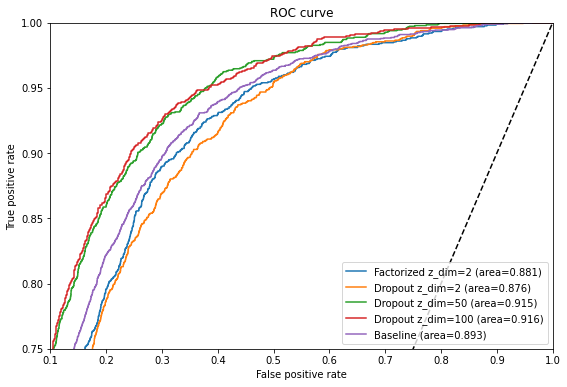

In [32]:
plt.figure(figsize=(9,6))
plt.xlim(0.1, 1)
plt.ylim(0.75, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_f_2, tpr_f_2, label='Factorized z_dim=2 (area={:.3f})'.format(ns_f_2))
plt.plot(fpr_d_2, tpr_d_2, label='Dropout z_dim=2 (area={:.3f})'.format(ns_d_2))
plt.plot(fpr_d_50, tpr_d_50, label='Dropout z_dim=50 (area={:.3f})'.format(ns_d_50))
plt.plot(fpr_d_100, tpr_d_100, label='Dropout z_dim=100 (area={:.3f})'.format(ns_d_100))
plt.plot(fpr_baseline, tpr_baseline, label='Baseline (area={:.3f})'.format(ns_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Noticed that we did not experiment higher **Z** dimension on the factorized model. The result was that tensorflow ran out of memory while trying to fit the factorized model on the full dataset. We will try to reduce **Z** dimension to a more feasible value and try again.

Generally, with a 2D dimensional latent space, the models performed worse than the mean baseline. It can be understood that the models were not able to capture the data distribution with a small dimensional space. Preliminary result also showed that the factorized encoder-decoder performed slightly better than the dropout one on a low dimensional space. 

As stated above, increasing the size of dimensional vector **Z** significantly improved the classifier's performance. The ROC curves steeped further to the top left corner which is equivalent to a bigger Area under Curve (AOC). 

# Conclusion

# References

- https://www.kaggle.com/jayjay75/wids2020-lgb-starter-adversarial-validation

- https://github.com/probabilistic-learning/HI-VAE

- HI-VAE paper: https://arxiv.org/abs/1807.03653

# Appendix

Notes:
- If a covariate is classified as **cat**, its value must be smaller than the dimension. Otherwise, tensorflow will throw an error **Check failed: work_element_count > 0 (0 vs. 0)**
- Training process is relatively slow. Consider reducing epochs if neded. Training on GPU is encouraged.

In [0]:
# Set this flag to true to allow sending partitioned data to files
# Otherwise, data will be read from files
file_partition = False

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/SGPM-2020

In [0]:
import pandas as pd
import missingno as mno
import matplotlib as plt
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
#Train test splitting
from sklearn.model_selection import train_test_split

In [0]:
!pip install -r pip_requirements.txt
!pip show tensorflow

In [0]:
train_df = pd.read_csv("training_v2.csv") # train data set
dt = pd.read_csv("WiDS Datathon 2020 Dictionary.csv") #data type

# Convert to tf dataset
uniq_categories = set(dt['Category'])

# Drop some columns
drop_cols = ["encounter_id","patient_id"]
train_df = train_df.drop(columns=drop_cols)

In [0]:
# Visualize missing data
def visualize_missing_cov(df):
    samples_df = df.sample(10000)

    for cat in uniq_categories:
        if cat in ["vitals", "demographic", "labs", "APACHE covariate", "labs blood gas"]:

            col_list = dt.loc[dt['Category'] == cat]["Variable Name"]
            col_list = [col for col in col_list if col in samples_df.columns]
            cat_df = pd.DataFrame(samples_df,columns=col_list)
            
            ax = mno.matrix(cat_df,figsize=(30, 10), labels=True)
            ax.set_title(cat, fontsize=30)
        
visualize_missing_cov(train_df)

In [0]:
# Before splitting, replace NaN values with 0
train_df_filled = train_df.copy()

trains = train_df_filled
targets = train_df_filled.loc[:, train_df_filled.columns == 'hospital_death']

X_train,X_test, y_train, y_test = train_test_split(trains, targets, test_size=0.2)

# Reset index before partitioning
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [0]:
# Partitioning data types 
def partition_types(df):
    types = []
    dim = []
    nclass = []

    for col in df.columns:
        if df[col].dtype == "float":
            if min(df[col].values) < 0:
                types.append("real")
            else:
                types.append("pos")
            dim.append(1)
            nclass.append(np.nan)
        if df[col].dtype == "int":
            if col == "icu_id" or col == "hospital_id":
                types.append("pos")
                dim.append(1)
                nclass.append(np.nan)
            else:
                types.append("cat")
                dim.append(2) # binary data
                nclass.append(2)
        if df[col].dtype == "O":
            types.append("cat")
            dims = df[col].unique() # Unique elements excluding NaN
            dims = len(dims)
            dim.append(dims)
            nclass.append(dims)
    return types, dim, nclass

types, dim, nclass =  partition_types(train_df) 
data_types_save = {'type': types, 'dim': dim, 'nclass': nclass}
data_types_pd = pd.DataFrame(data_types_save) 
data_types_pd.to_csv('Hospital/data_types.csv', index=False)

In [0]:
# Send  missing value positions to 2 files
def partition_missing_val_position(X):
    pos = []
    ids = []
    for idx, col in enumerate(list(X.columns)):
        list_nan_idx = list((X.loc[pd.isna(X[col]), :].index))
        locs = [idx+1] * len(list_nan_idx)
        pos = pos + list_nan_idx
        ids = ids + locs
    return pos, ids

# Save missing train
train_pos, train_ids = partition_missing_val_position(X_train)
train_d = {'pos': train_pos, 'idx': train_ids}  
missing_train = pd.DataFrame(train_d) 
missing_train.to_csv('Hospital/Missing33_0_train.csv', header=False, index=False)

# Save missing test
X_test["hospital_death"] = np.nan
test_pos, test_ids = partition_missing_val_position(X_test)
test_d = {'pos': test_pos, 'idx': test_ids}  
missing_test = pd.DataFrame(test_d) 
missing_test.to_csv('Hospital/Missing33_0_test.csv', header=False, index=False)
X_test["hospital_death"] = 0

In [0]:
# Data encoding
# Get categorical cols
cat_cols = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', "gender", "ethnicity", 'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
cat_cols_idx = [list(X_train.columns).index(col) for col in cat_cols]

def fill_na(X):
    float_cols = X.select_dtypes(include=['float64']).columns
    str_cols = X.select_dtypes(include=['object']).columns

    X.loc[:, float_cols] = X.loc[:, float_cols].fillna(0)
    X.loc[:, str_cols] = X.loc[:, str_cols].fillna('')
    return X

def category_encoding(X_train, X_test):
    le = preprocessing.LabelEncoder()

    for col in cat_cols:
        X_train_fit = X_train[col]
        X_test_fit = X_test[col]
        # Fit with unique values in both list
        X_fit = np.unique(X_train_fit.tolist()+X_test_fit.tolist())
        le = preprocessing.LabelEncoder().fit(X_fit)

        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        
    return X_train, X_test

X_train = fill_na(X_train)
X_test = fill_na(X_test)

X_train, X_test = category_encoding(X_train, X_test)

In [0]:
# Baseline: mean imputation
def mean_impute(t_df):

    df = t_df.copy()
    for col in df.columns:
        if df[col].dtype == "float":
            
            mean = df[col].mean(skipna = True) 
            df.loc[:, col] = df.loc[:, col].fillna(mean)
        if df[col].dtype == "int":
            mean = df[col].mean(skipna = True) 
            df.loc[:, col] = df.loc[:, col].fillna(mean)
        if df[col].dtype == "O":

            mean = df[col].value_counts().idxmax()
            df.loc[:, col] = df.loc[:, col].fillna(mean)

    train = df.loc[:, df.columns != 'hospital_death']
    targets = df.loc[:, df.columns == 'hospital_death']
    return train, targets

X_baseline, y_baseline = mean_impute(train_df)

# Encoding
X_b_train,X_b_test, y_b_train, y_b_test = train_test_split(X_baseline, y_baseline, test_size=0.2)
X_b_train, X_b_test = category_encoding(X_b_train, X_b_test)

In [0]:
#Send data to csv or load 
if file_partition == True:
    X_train.to_csv("Hospital/train_data.csv", header=False, index=False)
    X_test.to_csv("Hospital/test_data.csv", header=False, index=False)
    y_test.to_csv("Hospital/train_labels.csv", header=False, index=False)
    y_test.to_csv("Hospital/test_labels.csv", header=False, index=False)
    
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    missing_full = pd.concat([missing_train, missing_test]) 
    
    X.to_csv("Hospital/data_full.csv", header=False, index=False)
    y.to_csv("Hospital/labels_full.csv", header=False, index=False)
    missing_full.to_csv("Hospital/Missing33_0_full.csv", header=False, index=False)

    # Baseline
    X_baseline.to_csv("Hospital/train_baseline.csv", header=False, index=False)
    y_baseline.to_csv("Hospital/targets_baseline.csv", header=False, index=False)
else:
    X_train = pd.read_csv("Hospital/train_data.csv", header=None).values
    X_test = pd.read_csv("Hospital/test_data.csv", header=None).values
    y_train = pd.read_csv("Hospital/train_labels.csv", header=None).values
    y_test = pd.read_csv("Hospital/test_labels.csv", header=None).values

    X = pd.read_csv("Hospital/data_full.csv", header=None).values
    y = pd.read_csv("Hospital/labels_full.csv", header=None).values
    missing_full = pd.read_csv("Hospital/Missing33_0_full.csv", header=None).values

    X_baseline = pd.read_csv("Hospital/train_baseline.csv", header=None).values
    y_baseline = pd.read_csv("Hospital/targets_baseline.csv", header=None).values

In [0]:
# Hyper-params
dataset="Hospital"
batch_size=5000

z_dims= [2,50,100] # z latent space / embedding space 2,50,75
y_dim=2 # number of layers
s_dim=10*2 # embedding space
epoch = 100

m_perc=33
mask=0
model_dropout ="model_HIVAE_inputDropout"
model_factorized ="model_HIVAE_factorized"

In [0]:
# Train model
def train_model(model, z_dim, y_dim, s_dim, batch_size, dataset="Hospital",m_perc=33, mask=0, epoch=200):
    
    data_file= "{}/train_data.csv".format(dataset)
    types_file=  "{}/data_types.csv".format(dataset)
    miss_file= "{}/Missing{}_{}_train.csv".format(dataset, m_perc, mask)
    save_file = "{}_{}_{}_{}_{}".format(dataset,model,z_dim,s_dim,y_dim)
    print("Save file: ", save_file)
    !python main_scripts.py --model_name {model} --batch_size {batch_size} --epochs {epoch} --data_file {data_file} --types_file {types_file} --miss_file {miss_file} --dim_latent_z {z_dim} --dim_latent_y {y_dim} --dim_latent_s {s_dim} --save_file {save_file} --display 10

# Start training
for z_dim in z_dims:
    train_model(model=model_dropout,z_dim=z_dim, y_dim=y_dim, s_dim=s_dim, batch_size=5000)
    train_model(model=model_factorized,z_dim=z_dim, y_dim=y_dim, s_dim=s_dim, batch_size=5000)


In [0]:
# TEST MODEL
def test_model(model, z_dim, y_dim, s_dim, batch_size, dataset="Hospital",m_perc=33, mask=0):

    data_file= "{}/test_data.csv".format(dataset)
    types_file=  "{}/data_types.csv".format(dataset)
    miss_file = "{}/Missing{}_{}_test.csv".format(dataset, m_perc, mask)
    save_file = "{}_{}_{}_{}_{}".format(dataset,model,z_dim,s_dim,y_dim)
    !python main_scripts.py --model_name {model} --batch_size {batch_size} --epochs 1 --data_file {data_file} --types_file {types_file} --miss_file {miss_file} --dim_latent_z {z_dim} --dim_latent_y {y_dim} --dim_latent_s {s_dim} --save_file {save_file} --train 0 --restore 1 

for z_dim in z_dims:
    test_model(model=model_dropout,z_dim=z_dim, y_dim=y_dim, s_dim=s_dim, batch_size=20000)
    test_model(model=model_factorized,z_dim=z_dim, y_dim=y_dim, s_dim=s_dim, batch_size=20000)


In [0]:
# TEST FULL
def test_full_model(model, z_dim, y_dim, s_dim, batch_size, dataset="Hospital",m_perc=33, mask=0):
    data_file= "{}/data_full.csv".format(dataset)
    types_file=  "{}/data_types.csv".format(dataset)
    miss_file = "{}/Missing{}_{}_full.csv".format(dataset, m_perc, mask)
    save_file = "{}_{}_{}_{}_{}".format(dataset,model,z_dim,s_dim,y_dim)
    !python main_scripts.py --model_name {model} --batch_size {batch_size} --epochs 1 --data_file {data_file} --types_file {types_file} --miss_file {miss_file} --dim_latent_z {z_dim} --dim_latent_y {y_dim} --dim_latent_s {s_dim} --save_file {save_file} --train 0 --restore 1 

test_full_model(model=model_dropout,z_dim=100, y_dim=y_dim, s_dim=s_dim, batch_size=100000)    

In [0]:
# Evaluation
res_factorized_dir_2 = "Results/Hospital_model_HIVAE_factorized_2_20_2/"
res_inpDropout_dir_2 = "Results/Hospital_model_HIVAE_inputDropout_2_20_2/"
res_factorized_dir_50 = "Results/Hospital_model_HIVAE_factorized_50_20_2/"
res_inpDropout_dir_50 = "Results/Hospital_model_HIVAE_inputDropout_50_20_2/"
res_factorized_dir_100 = "Results/Hospital_model_HIVAE_factorized_100_20_2/"
res_inpDropout_dir_100 = "Results/Hospital_model_HIVAE_inputDropout_100_20_2/"

# Factorized, z_dim = 2
result_factorized_2 = pd.read_csv(res_factorized_dir_2 + "Hospital_model_HIVAE_factorized_2_20_2_data_reconstruction.csv", header=None)
X_factorized_2 = result_factorized_2.loc[:, result_factorized_2.columns != 1].values
y_factorized_2 = result_factorized_2[1].values

# Dropout, z_dim = 2
result_dropout_2 = pd.read_csv(res_inpDropout_dir_2 + "Hospital_model_HIVAE_inputDropout_2_20_2_data_reconstruction.csv", header=None)
X_dropout_2 = result_dropout_2.loc[:, result_dropout_2.columns != 1].values
y_dropout_2 = result_dropout_2[1].values

# Dropout, z_dim = 50
result_factorized_50 = pd.read_csv(res_factorized_dir_50 + "Hospital_model_HIVAE_factorized_50_20_2_data_reconstruction.csv", header=None)
X_factorized_50 = result_factorized_50.loc[:, result_factorized_50.columns != 1].values
y_factorized_50 = result_factorized_50[1].values

# Dropout, z_dim = 50
result_dropout_50 = pd.read_csv(res_inpDropout_dir_50 + "Hospital_model_HIVAE_inputDropout_50_20_2_data_reconstruction.csv", header=None)
X_dropout_50 = result_dropout_50.loc[:, result_dropout_50.columns != 1].values
y_dropout_50 = result_dropout_50[1].values

# Dropout, z_dim = 100
result_dropout_100 = pd.read_csv(res_inpDropout_dir_100 + "Hospital_model_HIVAE_inputDropout_100_20_2_data_reconstruction.csv", header=None)
X_dropout_100 = result_dropout_100.loc[:, result_dropout_100.columns != 1].values
y_dropout_100 = result_dropout_100[1].values

def evaluate(train, targets, model_name):
    
    X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.33, random_state=4)

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    y_test_prob = y_test_prob[:, 1]

    ns_auc = metrics.roc_auc_score(y_test, y_test_prob)
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)

    return ns_auc, fpr, tpr

In [0]:
ns_f_2, fpr_f_2, tpr_f_2 = evaluate(X_factorized_2,y_factorized_2, model_name="Factorized z_dim=2")
ns_d_2, fpr_d_2, tpr_d_2 = evaluate(X_dropout_2,y_dropout_2, model_name="Dropout z_dim=2")
ns_d_50, fpr_d_50, tpr_d_50 = evaluate(X_dropout_50,y_dropout_50, model_name="Dropout z_dim=50")
ns_d_100, fpr_d_100, tpr_d_100 = evaluate(X_dropout_100,y_dropout_100, model_name="Dropout z_dim=100")
ns_baseline, fpr_baseline, tpr_baseline = evaluate(X_baseline,y_baseline, model_name="Baseline")

In [ ]:
plt.figure(figsize=(9,6))
plt.xlim(0.1, 1)
plt.ylim(0.75, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_f_2, tpr_f_2, label='Factorized z_dim=2 (area={:.2f})'.format(ns_f_2))
plt.plot(fpr_d_2, tpr_d_2, label='Dropout z_dim=2 (area={:.2f})'.format(ns_d_2))
plt.plot(fpr_d_50, tpr_d_50, label='Dropout z_dim=50 (area={:.2f})'.format(ns_d_50))
plt.plot(fpr_d_100, tpr_d_100, label='Dropout z_dim=100 (area={:.2f})'.format(ns_d_100))
plt.plot(fpr_baseline, tpr_baseline, label='Baseline (area={:.2f})'.format(ns_baseline))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
labels = ["negative", "positive"]
print("Classfication report\n")
print("Dropout z_dim=2\n")
print(classification_report(y_test, y_dropout_2, target_names=labels))

print("Factorized z_dim=2\n")
print(classification_report(y_test, y_factorized_2, target_names=labels))

print("Dropout z_dim=50\n")
print(classification_report(y_test, y_dropout_50, target_names=labels))

print("Factorized z_dim=50\n")
print(classification_report(y_test, y_factorized_50, target_names=labels))

print("Factorized z_dim=100\n")
print(classification_report(y_test, y_dropout_100, target_names=labels))